### The goals / steps of this project are the following:

- **Section 1: Camera Calibration **
    - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    - Apply a distortion correction to raw images.

- ** Section 2: Thresholded Binary Image **
    - Use color transforms, gradients, etc., to create a thresholded binary image.

- ** Section 3: Perspective Trasnform **
    - Apply a perspective transform to rectify binary image ("birds-eye view").
    
- ** Section 4: Lane Detection **
    - Detect lane pixels and fit to find the lane boundary.
    - Determine the curvature of the lane and vehicle position with respect to center.
    - Warp the detected lane boundaries back onto the original image.
    
- ** Secton 5: Video Pipeline **
    - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    
- ** Section 6: Discussion **

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

## Section 1: Camera Calibration

In this Section, we compute camera calibration matrix using chessboard images given with the project. To compute the calibration matrix we use OpenCV function `calibrateCamera` and calibrate the corners of the chessboard images against gird.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

In [2]:
def get_calibration_matrix(calibration_img_dir, x_corners, y_corners):
    objp = np.zeros((x_corners * y_corners, 3), np.float32)
    objp[:,:2] = np.mgrid[0:x_corners, 0:y_corners].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calibration_img_dir)

    w, h, _ = mpimg.imread(images[0]).shape
    img_size = (w, h)

    sucess_image = 0
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x_corners, y_corners), None)
    
        if ret:
            sucess_image += 1
            objpoints.append(objp)
            imgpoints.append(corners)

    print("Total image %d, Sucess image %d" % (len(images), sucess_image))
    print("Training points ", len(objpoints), len(imgpoints))

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

In [3]:
x_corners = 9
y_corners = 6

start_time = time.time()

mtx, dist = get_calibration_matrix("camera_cal/calibration*", x_corners, y_corners)
print("Camera Matrix ", mtx.shape, "Number of dist coefficients ", len(dist[0]))

print("Time taken %ds" % (time.time() - start_time))

Total image 20, Sucess image 17
Training points  17 17
Camera Matrix  (3, 3) Number of dist coefficients  5
Time taken 6s


### Undistort images
- Below we show some sample undistored images, include a test image which will be used in pipeline

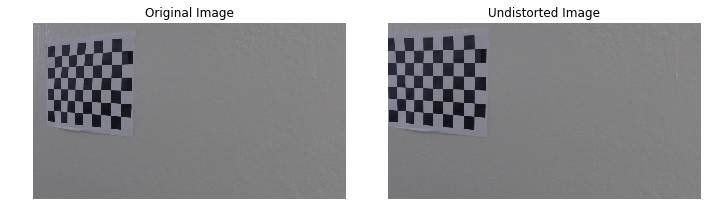

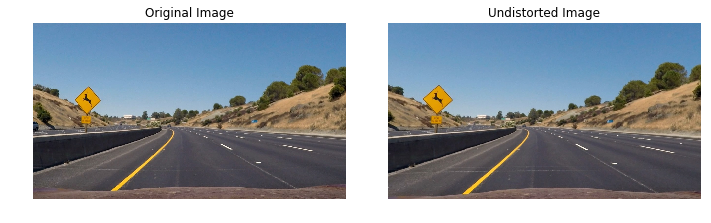

In [46]:
dst_dir = "output_images/undistort/"

images = glob.glob("camera_cal/*.jpg")
cal_img = images[np.random.randint(len(images))]

images = glob.glob("test_images/test*.jpg")
test_img = images[np.random.randint(len(images))]

images = [cal_img, test_img]
for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    dst_img = dst_dir + fname.split("/")[1]
    cv2.imwrite(dst_img, dst)
    
    img = plt.imread(fname)
    dst = plt.imread(dst_img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image')
    ax2.axis('off')
        
    plt.show()

### Save the undistored images
- We save all the test images in the folder `output_images/undistort/` for future use

In [5]:
dst_dir = "output_images/undistort/"
images = glob.glob("test_images/test*.jpg")

for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    dst_img = dst_dir + os.path.basename(fname)
    cv2.imwrite(dst_img, dst)

## Section 2: Thresholded Binary Image

** Use Sobel operator to compute gradients and apply various thresholds to create binary image **

We create the binary image by applying thresholds on following gradient values
1. Absolute value of the gradient
2. Magnitude of the gradient
3. Direction of the gradient 

In [56]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

### Visualize the output binary images of various thresholding schemes

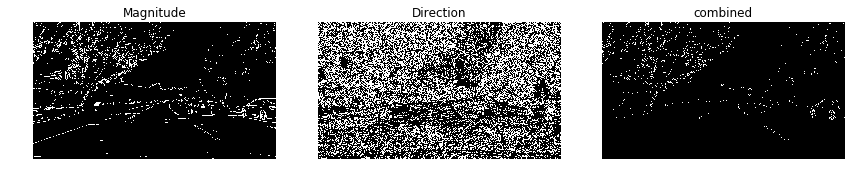

In [59]:
ksize = 3
thresh_min = 50
thresh_max = 150
m_thresh = (50, 255)
d_thresh = (0.2, np.pi/3)
fnames = glob.glob("output_images/undistort/test*.jpg")

for fname in fnames[4:6]:
    img = plt.imread(fname)

    gradx = abs_sobel_thresh(img, 'x', thresh_min, thresh_max)
    grady = abs_sobel_thresh(img, 'y', thresh_min, thresh_max)
    
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=m_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=d_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")
    
    ax2.imshow(gradx, cmap='gray')
    ax2.set_title("Gradx")
    ax2.axis("off")
    
    ax3.imshow(grady, cmap='gray')
    ax3.set_title("Grady")
    ax3.axis("off")
    
    plt.show()
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8))
    f.tight_layout()
    ax1.imshow(mag_binary, cmap='gray')
    ax1.set_title("Magnitude")
    ax1.axis("off")
    
    ax2.imshow(dir_binary, cmap='gray')
    ax2.set_title("Direction")
    ax2.axis("off")
    
    ax3.imshow(combined, cmap='gray')
    ax3.set_title("combined")
    ax3.axis("off")
    
    plt.show()

### Observations
- Combined gradient is less noisy and looks best
- But still it is not sufficient enough to detect the edges very cleanly

Next we try color transform and compute the gradient on specific color channel

### HLS Color Transform

Much sharper edges are detected using HLS color transform

In [60]:
def binary_image(img, s_thresh=(175, 255), sx_thresh=(20, 100)):
    # Convert to HSV color space and separate the V channel
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

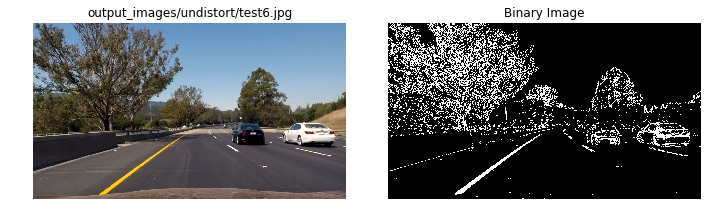

In [61]:
images = glob.glob("output_images/undistort/test*.jpg")

for fname in images[4:6]:
    img = mpimg.imread(fname)
    binary = binary_image(img)
 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(fname)
    ax1.axis('off')
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('Binary Image')
    ax2.axis('off')
        
    plt.show()

## Section 3: Perspective Transform

With some trial and error I found the following source and destination points that are working well in doing the perspective transform and providing `birds eye view` of the lanes

Source | Destination
--- | ---
193, 720 | 200, 720
585, 454 | 200, 0
697, 454 | 1080, 0
1116, 720 | 1080, 720

Below we have displayed the warped image (or perspective transformed image) and corresponding binary version

Note that in all cases the **only** the lane lines are reasonably visible in the binary image

In [62]:
def perspective_transform(img):
    src = np.float32([[193, 720],[585, 454],[697, 454],[1116, 720]])
    dst = np.float32([[200, 720], [200, 0], [1080, 0],[1080, 720]])

    image_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

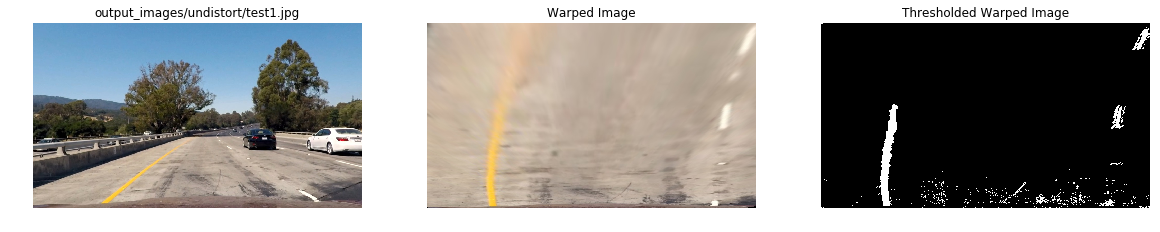

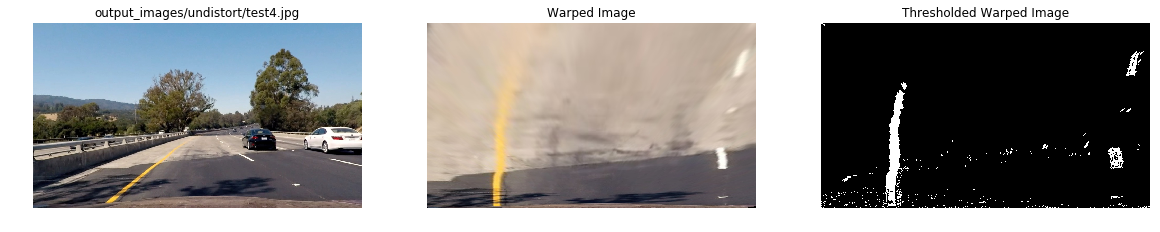

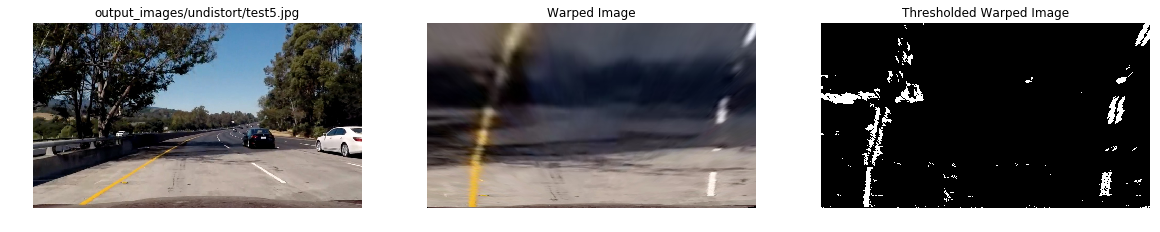

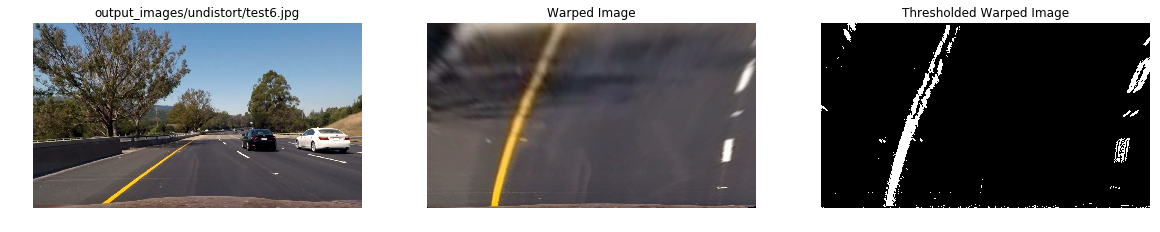

In [63]:
out_dir = "output_images/warped/"
test_images = glob.glob('output_images/undistort/test*.jpg')


for fname in test_images:
    img = mpimg.imread(fname)
    warped_img, Minv = perspective_transform(img)
    warped_img = cv2.cvtColor(warped_img, cv2.COLOR_RGB2BGR)

    outfile = out_dir +  os.path.basename(fname)
    cv2.imwrite(outfile, warped_img)    
    
for fname in test_images:
    img = mpimg.imread(fname)
    outfile = out_dir +  os.path.basename(fname)
    warped_img = mpimg.imread(outfile)
    binary_img = binary_image(warped_img)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))   
    ax1.imshow(img,)
    ax1.set_title(fname)
    ax1.axis('off')

    ax2.imshow(warped_img, cmap='gray')
    ax2.set_title('Warped Image')
    ax2.axis('off')
    
    ax3.imshow(binary_img, cmap='gray')
    ax3.set_title('Thresholded Warped Image')
    ax3.axis('off')

## Section 4: Lane Detection

- We adopted the method (and code) provided in the course lectures.
- We run 2 sets (left and right) of sliding windows from the bottom of the image to the top. 
- In each window, we take the nonzero pixels and add those to an index array
- We then fit a 2nd order polynomial on those nonzero pixels. We fit 2 separate polynomials for left and right points

In [12]:
def fit_poly_sliding_window(binary_warped, visualize=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

#         Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if visualize:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        window_img = np.zeros_like(out_img)
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        return left_fitx, right_fitx, ploty, out_img
    
    return left_fitx, right_fitx, ploty

### Visualize the polynomial fit

In [13]:
img = mpimg.imread("output_images/warped/test2.jpg")
binary_warped = binary_image(img)
    
left_fitx, right_fitx, ploty, out_img = fit_poly_sliding_window(binary_warped, visualize=True)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.axis("off")

/Users/s6baner/anaconda/envs/sdcnd/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(-0.5, 1279.5, 719.5, -0.5)

### Measure Radius of Curvature

Use the formula provided in the course lecture

In [64]:
# Define conversions in x and y from pixels space to meters
def radius_of_curvature(left_fitx, right_fitx, ploty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    left_fit = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return np.average([left_curverad, right_curverad])

In [65]:
radius_of_curvature(left_fitx, right_fitx, ploty)

330.95255109781243

## Section 5: Video Pipeline

`draw_lanes` functions takes an image and performs the following steps
1. undistorts the image using undistortion and camera matrix we have obtained earlier
2. creates warped or perspective transformed image
3. transforms colors, compute gradients, apply thresholds and creates a thresholded binary image
4. runs sliding window to detect non-zero pixels and fits a polynomial
5. draws the lanes based on the detected ploynomial
6. unwarp the image and apply the lane markers on the original image

The Video Pipeline will call this `draw_image` function for every frame 

** Output Videos ** are uploaded as follows
- [project_video_out.mp4](project_video_out.mp4)
- [challenge_video_out.mp4](challenge_video_out.mp4)

In [48]:
def draw_lanes(image):
    img = cv2.undistort(image, mtx, dist, None, mtx)
    warped, Minv = perspective_transform(img)
    warped = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
    binary_warped = binary_image(warped)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx, right_fitx, ploty = fit_poly_sliding_window(binary_warped)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    curve_rad = radius_of_curvature(left_fitx, right_fitx, ploty)
    cv2.putText(result, 'Radius of curvature (m): {:.2f}'.format(curve_rad),
                (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

    return result

### Visualize the detected lanes on the test images

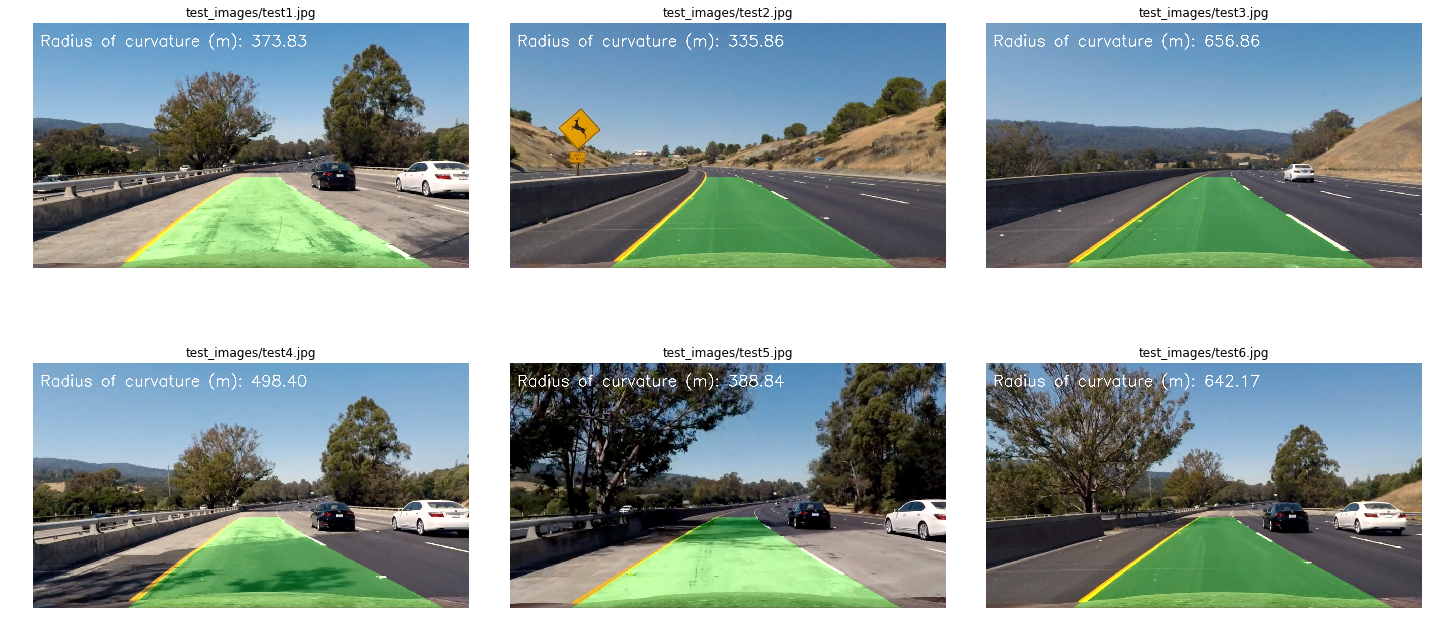

In [49]:
images = glob.glob("test_images/test*.jpg")

plt.figure(figsize=(20, 10))
for i in range(len(images)):
    fname = images[i]
    img = mpimg.imread(fname)
    result = draw_lanes(img)

    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(fname)
    plt.imshow(result)
    plt.axis("off")
plt.tight_layout()

### Apply on Video
Output videos are stored as follows
- [project_video_out.mp4](project_video_out.mp4)
- [challenge_video_out.mp4](challenge_video_out.mp4)

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
prj_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(draw_lanes)
%time clip_test_out.write_videofile(prj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:11<00:00,  6.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 11min 46s, sys: 1min 25s, total: 13min 12s
Wall time: 3min 12s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(prj_out_file))

In [54]:
chlng_out_file = 'challenge_video_out.mp4'
clip_test = VideoFileClip('challenge_video.mp4')
clip_test_out = clip_test.fl_image(draw_lanes)
%time clip_test_out.write_videofile(chlng_out_file, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [01:00<00:00,  8.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 3min 50s, sys: 21.8 s, total: 4min 12s
Wall time: 1min 1s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chlng_out_file))

## Section 6: Discussion

- ** Problems Issues Faced **
- Many different parameters to explore, different colors, so many thresholds
- Getting the edges (lanes) properly visible on the threholded binary image was a challenge. For low threshold values lots of noise were showing up and for high threshold values the lanes were not detected. Took some trial and error to get the thresholds and color space correct for the thresholded binary image

- ** Where the pipeline likely to fail **
- Too much shadow
- Change in the color of road or change in shade in the middle of the road as available in the challenge video
- Change in the slopes of the road (e.g. mountain roads)

- ** How to make it more robust **
- Better tracking of lanes across video frame and use the lanes detected on previous frames to correct detect lanes.
- Try to maintain the equal distance of the lanes across video frames